In [196]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from copy import deepcopy

In [197]:
# first lets download the dataset for our classification task
!pip install gdown  

!gdown https://drive.google.com/uc?id=1qwTfk-Dq_v5cyAPyNk7zn0DTGwnYKOv1

zsh:1: no matches found: https://drive.google.com/uc?id=1qwTfk-Dq_v5cyAPyNk7zn0DTGwnYKOv1


In [198]:
def extract_tarfile(_tar_file, _local_file):
    shutil.unpack_archive(_tar_file, _local_file)

local_tar_file = "custom_cifar.tar.gz"
local_file = local_tar_file.split(".tar.gz")[0]

extract_tarfile(local_tar_file, local_file)

local_dir = os.path.join(local_file, "custom_cifar")

train_data = np.load(os.path.join(local_dir, "train_images.npy"))
train_labels = np.load(os.path.join(local_dir, "train_labels.npy"))

valid_data = np.load(os.path.join(local_dir, "valid_images.npy"))
valid_labels = np.load(os.path.join(local_dir, "valid_labels.npy"))

test_data = np.load(os.path.join(local_dir, "test_images.npy"))
test_labels = np.load(os.path.join(local_dir, "test_labels.npy"))

class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

## Task 1:
Plot a few images from the train dataset together with its labels, so that you get an idea what the dataset is about. The dictionary `class_names` should help you with that. (Optional but helpful for later: Also have a look at the number of images in your training validation and test dataset.)

No handles with labels found to put in legend.


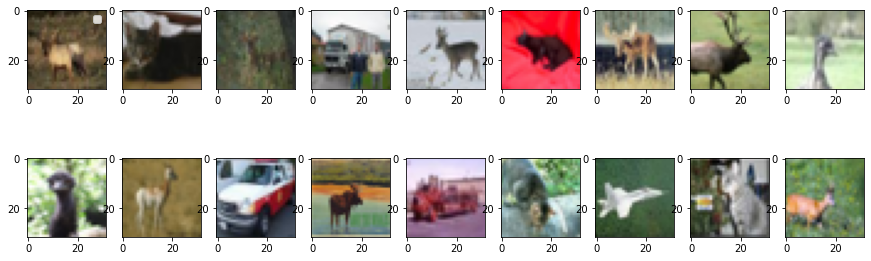

In [199]:
fig,ax=plt.subplots(2,9,figsize=(15,5))
ax=ax.ravel()
for j,im in enumerate(train_data[:18]):
    #print(im)
    ax[j].imshow(im,label=class_names[train_labels[j]])
ax[0].legend()

In [200]:
# your code
for lb in class_names:
    print(lb)

0
1
2
3
4
5
6
7
8
9


## Task 2:
Create a function that can calculate the accuracy given two vectors, one with predicted labels, one with true labels. The function will also have a keyword which lets you calculate the micro and macro accuracy. Remember that network predictions are not integer labels yet! You first have to convert the network output vector into an integer label to calculate the accuracy.

The following code is meant to help you, but if you find it rather confusing, just reuse the function name and write it from scratch yourself:

In [201]:
def calculate_accuracy(predictions, targets, num_classes=10, average="micro"):
    # Remember to first convert the predictions to integers, so that `integer_predictions` will become one_dimensional and only contain the value for
    # the predicted class (shape = [batch_size], there is no dimension for the classes anymore, because it would be one-dimensional)
    
    integer_predictions = torch.max(predictions,dim=1)[1] #... # your code
    
    match=[]
    
    accuracy_calc=0
    
    accuracy=0
    
    if average == "micro":
          
        acc_calc=torch.where(integer_predictions==targets,torch.ones(1),torch.zeros(1))
        
        accuracy=torch.mean(acc_calc)
    
    elif average == "macro":
        
        macro = torch.zeros(10)
        
        pred_group_label=0
    
        for i in range(10):
            
            pred_group_indices=torch.where(integer_predictions==i)
    
            pred_group_label=integer_predictions[pred_group_indices]
            
            acc_calc=torch.where(pred_group_label==targets[pred_group_indices],torch.ones(1),torch.zeros(1))

            macro[i]=acc_calc.nanmean()
        
        accuracy= macro.nanmean()
        
    return accuracy

The following sample values will help you to use the correct shape for your functions. They are the same as a neural network will output. The first dimensions (here 1000) will be the batch-size or dataset-size, the second (here 10) will be the number of classes. Remember, the NN will output a single value for each class separately, thats why he predictions will have the shape `[batch-size, num_classes]`. Make sure your accuracy function works with the following values and outputs reasonable values (also think about, what would be reasonable values here...):

In [202]:
predictions = torch.randn(size=(1000, 10))
labels = torch.randint(10, size=(1000, ))

print(calculate_accuracy(predictions,labels, average="micro"))
print(calculate_accuracy(predictions,labels, average="macro"))

tensor(0.1030)
tensor(0.1036)


In [203]:
predictions.size()

torch.Size([1000, 10])

## Task 3:
Build a small Convnet with 4 convolutional layers followed by an average-pooling (`torch.nn.functional.avg_pool2d()`) and finally a single fully connected layer. The convolutions all should use 10 filters, padding with zeros (called `same` padding in torch), a kernel_size of (3x3) and a stride of (1x1). Remember that the number of output unints of the fully connected layer has to be the same as the number of classes in your dataset. The reason for this is, that each output node will represent the probability for one class (well it will be a probability only after you applied the softmax or log-softmax function, see the lecture slides for more information). Do not apply a softmax inside your network, because we will later use `torch.nn.CrossEntropyLoss`.

Hints:
1. Use a `x.flatten(start_dim=1)` after the last convolution, because the fully connected (`torch.nn.Linear()`) layer will expect a 1-D input.
2. When calculating the size of the fully connected input,  remember that `torch.nn.functional.avg_pool2d()` which comes right before it, halves the size in both the width and the height dimension

In [204]:
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels=3, n_outputs=10):
        super(ConvNet, self).__init__()

        conv_specs = dict(
            kernel_size=(3,3),
            padding="same",
            stride=(1,1)
        )

        self.first_conv = torch.nn.Conv2d(input_channels,n_outputs,**conv_specs)
        self.second_conv = torch.nn.Conv2d(n_outputs,n_outputs,**conv_specs)
        self.third_conv = torch.nn.Conv2d(n_outputs,n_outputs,**conv_specs)
        self.four_conv = torch.nn.Conv2d(n_outputs,n_outputs,**conv_specs)
        
        self.relu = torch.nn.ReLU()
    
        self.fully_connected = torch.nn.Linear(n_outputs*16*16,n_outputs)  #linear_input_channels has to be calculated here

    def forward(self, x):
        x = self.first_conv(x)
        
        x = self.relu(x)       
        x = self.second_conv(x)
        
        x = self.relu(x)       
        
        x = self.third_conv(x)
        
        x = self.relu(x)       
        
        x = self.four_conv(x)
        
        x = torch.nn.functional.avg_pool2d(x,kernel_size=2)
        
        x = x.flatten(start_dim=1)
        
        x = self.fully_connected(x)
        

        return x


 The following cell will only check if you created your model correctly. If no error is thrown, then everything worked out fine:

In [205]:
model = ConvNet()

example_batch = torch.randn(size=(5, 3, 32, 32))
example_out = model(example_batch)
print(example_out.shape)

assert example_out.shape == (5, 10), "You made a mistake building your model output layer. Your model should output " \
    " 5 by 10 values [batch_size, num_classes]"

torch.Size([5, 10])


## Task 4:
Now create a training loop and train your network. Use the Adam optimizer with a batch-size of 64 samples. You can play around with the learning rate. Train the model for at least 10 epochs and after each epoch use the validation dataset to evaluate your model. During training calculate and track:
1. The Loss (use `torch.nn.CrossEntropyLoss`)
2. The micro-averaged accuracy
3. The macro-averaged accuracy

Also track these values for the complete validation dataset at the end of each epoch. Use your own accuracy function which you have created earlier.

I already created a dataset `CustomDataset` with according dataloaders for you to use.

Hint: Training the model for 10 epochs will take ~ 5 minutes on colab CPUs. So
during development make sure to only run your model for a single epch first and
make sure everything works. You might need to get back to Task 3 and refine
your model if the outputs look not correct.

In [206]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, item):
        data = self.images[item]
        label = self.labels[item]

        if self.transforms:
            data = self.transforms(data)

        return data, torch.tensor(label).long()

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_data, train_labels, transforms=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
whole_set_train = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

valid_dataset = CustomDataset(valid_data, valid_labels, transforms=ToTensor())
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
whole_set_valid = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)


test_dataset = CustomDataset(test_data, test_labels, transforms=ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
whole_set_test = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [207]:
def training_loop2(learning=0.001,numb_epochs=1,lossfunction='CrossEntropyLoss',optimizer_inp='Adam',
                   train_iterator_inp=train_dataloader,val_iterator_inp=valid_dataloader,filename= None):
    
    model_exp = ConvNet()
    
    training_loss_exp, validation_loss_exp = [], []
    
    n_epochs_stop = 5
    epochs_no_improve = 0
    check_val_exp = 0
    val_step=0
    
    ### lists for storing micro and macro accuracy on validation data ####
    valid_micro = []
    valid_macro = []
    train_micro = []
    train_macro = []
    all_val_steps = []
    avg_val_micro = []
    avg_val_macro = []

    #### set optimizer and loss function to user input #####
    
    if lossfunction == 'MSELoss':
        lossfunc = torch.nn.MSELoss()
    if lossfunction == 'CrossEntropyLoss':
        lossfunc = torch.nn.CrossEntropyLoss()
    ## set optimizer function to user input, only two options
    if optimizer_inp == 'SGD':
        optimizer = torch.optim.SGD(model_exp.parameters(), lr=learning)
    if optimizer_inp == 'Adam':
        optimizer = torch.optim.Adam(model_exp.parameters(), lr=learning)
        
    for epoch in range(numb_epochs):        
        loss_sum_exp = 0
        
        model_exp.train() ## training mode
        
        for batch in train_iterator_inp:
            
            x_batch, y_batch = batch
            
            optimizer.zero_grad() # zero the gradients

            yhat_batch = model_exp(x_batch)
                        
            loss_exp = lossfunc(yhat_batch,y_batch)#y_batch.long())
            loss_exp.backward()
            optimizer.step()
            
            training_loss_exp.append(loss_exp.item()/len(train_iterator_inp))
            
            micro_acc=calculate_accuracy(yhat_batch, y_batch, num_classes=10, average="micro")
            macro_acc=calculate_accuracy(yhat_batch, y_batch, num_classes=10, average="macro")
            
            train_micro.append(micro_acc.data)
            train_macro.append(macro_acc.data)


        val_loss_exp_sum=0
        val_loss_exp = 0
    
        model_exp.eval()  ## eval mode        
        with torch.no_grad():
            for batch_val in val_iterator_inp:

                x_batch_val,y_batch_val = batch_val
                y_hat_val = model_exp(x_batch_val)
                
                val_loss_exp = lossfunc(y_hat_val,y_batch_val)

                micro_acc_v=calculate_accuracy(y_hat_val,y_batch_val, num_classes=10, average="micro")
                macro_acc_v=calculate_accuracy(y_hat_val,y_batch_val, num_classes=10, average="macro")
                
                valid_micro.append(micro_acc_v.data)
                valid_macro.append(macro_acc_v.data)
                
                val_step+=1
        
        all_val_steps.append(val_step)
        
        avg_val_micro.append(np.mean(valid_micro))
        avg_val_macro.append(np.mean(valid_macro))
        
        validation_loss_exp.append(val_loss_exp.item()/len(val_iterator_inp))


        #print(loss_sum_exp/len(train_iterator_inp))

        print('--------Training in progress-------------,Epoch='+str(epoch))


        if val_loss_exp_sum/len(val_iterator_inp)==np.min(validation_loss_exp):

            previous_state_exp=deepcopy(model_exp.state_dict())

            torch.save(previous_state_exp,filename)

        if check_val_exp<val_loss_exp_sum:

            epochs_no_improve +=1

                #print('Checkvalue:'+str(check_val_exp))

                #print('Actual Value:'+str(val_loss_exp_sum))


        else:
            epochs_no_improve = 0

            check_val_exp = val_loss_exp_sum

        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            break


    return validation_loss_exp,training_loss_exp,valid_micro,valid_macro,train_micro,train_macro,all_val_steps,avg_val_micro,avg_val_macro,model_exp ### return the prediction, 
#validation and training loss for each training loop over the combinations of parameters


In [208]:
## run the training loop for ten epochs #####

params=dict(learning=0.002,numb_epochs=10,lossfunction='CrossEntropyLoss',
            optimizer_inp='Adam',train_iterator_inp=train_dataloader,
            val_iterator_inp=valid_dataloader,filename='best_params.pth')
                    
valido,traino,valid_micro,valid_macro,train_micro,train_macro,all_val_steps,avg_val_micro,avg_val_macro,modelo = training_loop2(**params)




--------Training in progress-------------,Epoch=0
--------Training in progress-------------,Epoch=1
--------Training in progress-------------,Epoch=2
--------Training in progress-------------,Epoch=3
--------Training in progress-------------,Epoch=4
--------Training in progress-------------,Epoch=5
--------Training in progress-------------,Epoch=6
--------Training in progress-------------,Epoch=7
--------Training in progress-------------,Epoch=8
--------Training in progress-------------,Epoch=9


## Task 5:
Create a few line plots showing how the metrics that you tracked progressed. You can use the varialbe `val_step` to plot validation and training data on the same plot, because `val_step` will give you the correct positions on the x_axis for the validation results.

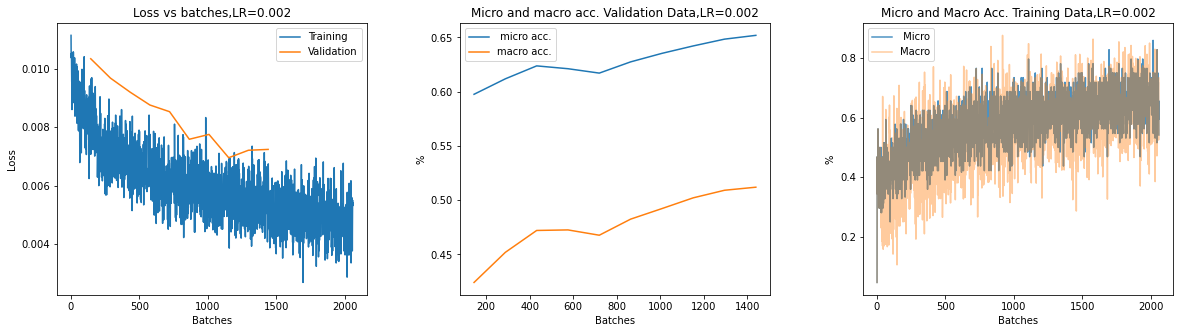

In [209]:
#  plot the average micro and macro accuracies for validation and training, 
#and plot the normalized loss ###
LR=0.002

epochs_fast=np.arange(0,n_epochs,1)

fig,ax=plt.subplots(1,3,figsize=(20,5))
ax=ax.ravel()
fig.subplots_adjust(hspace=0.4,wspace=0.3)

ax[0].plot(traino,label='Training')
ax[0].plot(all_val_steps,valido,label='Validation')

ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title("Loss vs batches,LR="+str(LR) )


ax[1].plot(all_val_steps,avg_val_micro,label=' micro acc.')
ax[1].plot(all_val_steps,avg_val_macro,label='macro acc.')


ax[1].set_ylabel('%')
ax[1].set_title("Micro and macro acc. Validation Data,LR="+str(LR))
ax[1].set_xlabel('Batches')

ax[2].plot(train_micro,label=" Micro",alpha=0.8)
ax[2].plot(train_macro,label= "Macro",alpha=0.4)
ax[2].set_title("Micro and Macro Acc. Training Data,LR=" +str(LR))
ax[2].set_ylabel('%')
ax[2].set_xlabel('Batches')



ax[0].legend()
ax[1].legend()
ax[2].legend()

## Task 6:
Create 3 confusion matrices using your trained model: 1 for the training data, 1 for the validation data, and 1 for the test data. Also compute one average loss, one average micro accuracy and one average marco accuracy for each complete dataset. You can use the implementation from `sklearn` to create and plot the matrices. Look at the documentation for further instructions on how to use them.

In [210]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sets = [train_dataset,valid_dataset,test_dataset]

dataloaders = [train_dataloader, valid_dataloader, test_dataloader]


confusions = []

loss_ls=[]

mic = []

mac = []

every_loss = []

every_micro = []

every_macro = []


model_exp = modelo


model_exp.eval()

lossfunc=torch.nn.CrossEntropyLoss()
    
with torch.no_grad():

    for i,bato in enumerate(dataloaders):
        print(i)
    
        compl_predicts = torch.zeros(len(sets[i]),10)
        
        compl_targets = torch.zeros(len(sets[i]))
        

        for j,gallo in enumerate(bato):

            xdat,ydat=gallo

            y_pred = model_exp(xdat)

            start = j+j*(len(xdat)-1)

            end = start + len(xdat)

            compl_predicts[start:end] = y_pred

            compl_targets[start:end] = ydat

            loss = lossfunc(y_pred,ydat)

            loss_ls.append(loss/len(xdat))

            micro_acc=calculate_accuracy(y_pred, ydat,num_classes=10, average="micro")

            macro_acc=calculate_accuracy(y_pred, ydat, num_classes=10, average="macro")

            mic.append(micro_acc.data)

            mac.append(macro_acc.data)

        every_loss.append(np.mean(loss_ls))

        every_micro.append(np.mean(mic))

        every_macro.append(np.mean(mac))

        target_np = np.array(compl_targets)

        predict_np = compl_predicts.argmax(dim=1).numpy()

        confusion=confusion_matrix(target_np,predict_np)
        
        #confusion=ConfusionMatrixDisplay.from_predictions(target_np,predict_np)

        confusions.append(confusion)
print('done')

0
1
2
done


In [211]:
print('First value= Training,Second Value =Validation,Third value= Testing')
print(" Average Micro accuracies by dataset=" +str(every_micro))
print(" Average Macro accuracies by dataset=" +str(every_macro))
print(" Average Loss by dataset=" +str(every_loss))

First value= Training,Second Value =Validation,Third value= Testing
 Average Micro accuracies by dataset=[0.6970824, 0.6913988, 0.63043433]
 Average Macro accuracies by dataset=[0.6731701, 0.61725736, 0.5905327]
 Average Loss by dataset=[0.014002252, 0.014637268, 0.017312549]


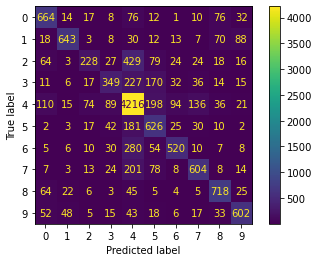

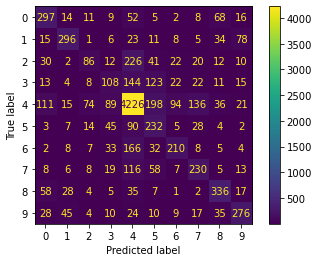

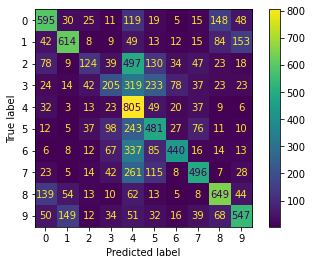

In [212]:
import seaborn as sns
#fig,ax=plt.subplots(1,3)
#ax=ax.ravel()
titles=['Trained Model(Training Data)','Trained Model(Validation Data)','Trained Model(Test Data)']

for i in range(3):
    
    disp=ConfusionMatrixDisplay(confusion_matrix=confusions[i])

    disp.plot()
    #disp.title=(titles[i])

## Task 7:
Using your results from task 5 and 6 what do you notice? 
1. Is your model already converged on the training data? 
2. Why are micro and macro averaged accuracies so different (hint look at the confusion matrices)? 
3. Why are the scores on the testing data so different?
4. What could we change or do to get better results?

#### Your answers go here.

### 1. My model has  already converged on the training data, the loss on the training data is levelling out.

### 2.I would expect the micro and macro averaged accuracies to be different because the data set is imbalanced. There are a large amount of images in the class label 4, which should make the macro accuracy much larger than the micro. A large amount of images in label 4 will inflate the macro accuracy because the network will more often give a correct prediction on label 4, relative to other categories.

### 3. I would expect the scores on the testing data to be different because the testing data is not as imbalanced, it has around 1000 images per label. 

### 4. To get better results, we can down or upsample our imbalanced data, or we can introduce a weighting on the loss, which will punish the network more if its predictions is wrong for an underrepresented class. Further, we can use Baye's theorem to calibrate the prediction based on the known distribution of labels .